In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import itertools

#Qiskit
from qiskit import *
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.opflow import I, X, Y, Z

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

import sys
sys.path.append('../')

/tmp/ipykernel_285599/2301690647.py:19: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
# Before running this code, you need to load your account using the API token available
# in your welcome page of the IBM Quantum website (https://quantum-computing.ibm.com/). 
# In the first time, you will need to use the command IBMQ.save_account(your_token) 
# to save your account.

# IBMQ.save_account(your_token)
IBMQ.load_account()

# Fill the information (hub, group and project) about your provider
hub = ''
group = ''
project = ''

provider = IBMQ.get_provider(hub=hub,
                             group=group,
                             project=project)

backend = provider.get_backend('ibm_lagos')
back_str = str(backend)
print("Backend:", backend)

Backend: ibm_lagos


In [3]:
# Get noise model from backend
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Define layout for transpilation 
initial_layout = [0, 1, 3, 5]

In [4]:
depth = 1 #Ansatz depth
n_rotations = 3 #Number of rotations parameters in each layer of the ansatz
nr_qubits = 1 #Number of qubits

### System Parameters

In [5]:
Iqml = np.identity(2)
Zqml = np.array([[1,0],[0,-1]])

#Temperature
T1 = 0.4
T2 = 0.8

beta_c = 1/T1 # 1/T1
beta_h = 1/T2 # 1/T2

# Parameters
w1 = 0.75
w2 = 1
wc = w1
wh = w2

gch = 0.8
g12 = 0.8

# Strokes durations
tq = 1
tw = 1

# Number of Measurement
N = 8

#Trotter steps
M = 1

H1_sim = (w1 / 2) * Zqml
H2_sim = (w2 / 2) * Zqml

Hc_sim = (wc / 2) * Zqml
Hh_sim = (wh / 2) * Zqml

Hc = (wc / 2) * Z
Hh = (wh / 2) * Z

### Ansatz

In [6]:
def qc_vqt(nr_qubits, depth, parameters, wires):

    qc1 = QuantumCircuit(nr_qubits)
    m = 0 
    for i in range(depth):
        #RZ-SX-RZ-SX-RZ
        qc1.rz(parameters[m], wires)
        qc1.sx(wires)
        qc1.rz(parameters[m+1], wires)
        qc1.sx(wires)
        qc1.rz(parameters[m+2], wires)
        m=m+3
    
    #Edit this part to includ dimensions > 2
    qc2 = QuantumCircuit(nr_qubits)
    qc2.x(wires)

    qc2 = qc2.compose(qc1)

    qc1 = qc1.reverse_bits()
    qc2 = qc2.reverse_bits()

    return [qc1, qc2]

In [7]:
# Ansatz Parameters

phis = ['phi'+str(n) for n in range(depth*n_rotations)] #3 rotations
phi = [Parameter(ang) for ang in phis]

ansatz_c = qc_vqt(nr_qubits=2, depth=depth, parameters=phi, wires=0)
ansatz_h = qc_vqt(nr_qubits=2, depth=depth, parameters=phi, wires=1)

backend_sim = Aer.get_backend('qasm_simulator')

backend = backend_sim

In [8]:
from VQT import VQT

vqt_instance_c = VQT(Hc, beta_c, ansatz_c, backend)
vqt_instance_h = VQT(Hh, beta_h, ansatz_h, backend)

Training...
Cost at Step 0: -1.0478593464259627
Cost at Step 5: -0.5561766176507827
Cost at Step 10: -1.0657123544536276
Cost at Step 15: -1.0789137971659093
Finished after 20 steps.


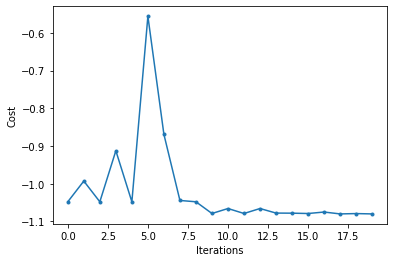

In [9]:
out_params_c, cost_c = vqt_instance_c.out_params(nr_qubits, depth)

Training...
Cost at Step 0: -1.0478593464259627
Cost at Step 5: -0.5561766176507827
Cost at Step 10: -1.0657123544536276
Cost at Step 15: -1.0789137971659093
Finished after 20 steps.


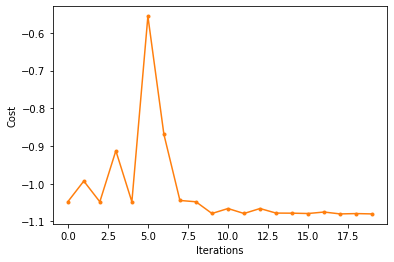

In [10]:
out_params_h, cost_h = vqt_instance_c.out_params(nr_qubits, depth, plot_color='tab:orange')

In [11]:
qc_barrier = QuantumCircuit(2)

qc_barrier.barrier()

qc_barrier = qc_barrier.reverse_bits()

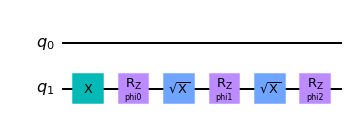

In [12]:
qc_c1 = ansatz_c[0]
qc_c2 = ansatz_c[1]
qc_c2.draw('mpl')

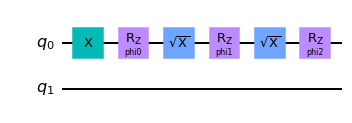

In [13]:
qc_h1 = ansatz_h[0]
qc_h2 = ansatz_h[1]
qc_h2.draw('mpl')

In [14]:
from VQT import prob_dist

# Prepares the optimal parameters and distribution for Hc
dist_params_c = out_params_c[0]
unitary_params_c = out_params_c[1:]
distribution_c = prob_dist(dist_params_c)

# Prepares the optimal parameters and distribution for Hh
dist_params_h = out_params_h[0]
unitary_params_h = out_params_h[1:]
distribution_h = prob_dist(dist_params_h)

# Parameters Bindings
phi_dict_c = dict(zip(phi, unitary_params_c))
phi_dict_h = dict(zip(phi, unitary_params_h))

# Bind Parameters to circuits
qc_c1_bind = qc_c1.bind_parameters(phi_dict_c)
qc_c2_bind = qc_c2.bind_parameters(phi_dict_c)
qc_h1_bind = qc_h1.bind_parameters(phi_dict_h)
qc_h2_bind = qc_h2.bind_parameters(phi_dict_h)

thermal_circs = [qc_c1_bind.compose(qc_h1_bind),
                 qc_h2_bind.compose(qc_c1_bind),
                 qc_c2_bind.compose(qc_h1_bind),
                 qc_c2_bind.compose(qc_h2_bind)]

In [15]:
# Generate the state tomography circuits.
qst = []
for circuit in thermal_circs:
    qst.append(state_tomography_circuits(circuit, [0, 1]))
    
#qst = np.reshape(qst,(1,36))
#qst = list(qst[0])
#print(qst)

In [16]:
#Backend
backend_sim = Aer.get_backend('qasm_simulator')
shots = 8192 #Number of shots

results = []
for i in range(len(thermal_circs)):
    job = execute(qst[i],
                  backend = backend_sim,
                  noise_model=noise_model,
                  coupling_map=coupling_map,
                  basis_gates=basis_gates,
                  shots = shots)
    job_monitor(job, interval=2)
    results.append(job.result())

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [17]:
rhos = []
for i in range(len(thermal_circs)):
    # Fit result
    tomo_fitter = StateTomographyFitter(results[i], qst[i])
    rhos.append(tomo_fitter.fit(method='lstsq'))
    #tomo_fitter.fit(method='lstsq')

In [18]:
# Initializes the density matrix

final_density_matrix = np.zeros((2 **2, 2 ** 2))

combos = itertools.product([0, 1], repeat=2)
s = [list(c) for c in combos]

dist_final = prob_dist([dist_params_c,dist_params_h])

for i, sample in zip(s,rhos):
    dist_aux = 1
    for j in range(0, len(i)):
        dist_aux = dist_final[j][i[j]]*dist_aux
    final_density_matrix = np.add(final_density_matrix, dist_aux*sample)

In [19]:
print(final_density_matrix)

[[ 1.81716918e-02+0.00000000e+00j -6.56767394e-04+1.21568553e-04j
   1.61820061e-03-8.47847579e-04j  3.05711723e-03+8.34100887e-05j]
 [-6.56767394e-04-1.21568553e-04j  1.19213066e-01+0.00000000e+00j
  -2.62179517e-03+2.81892315e-03j  4.72084361e-03-1.69223709e-03j]
 [ 1.61820061e-03+8.47847579e-04j -2.62179517e-03-2.81892315e-03j
   1.14827261e-01+0.00000000e+00j -2.44479894e-03+3.95555471e-03j]
 [ 3.05711723e-03-8.34100887e-05j  4.72084361e-03+1.69223709e-03j
  -2.44479894e-03-3.95555471e-03j  7.47787981e-01+0.00000000e+00j]]


In [20]:
from VQT import create_target

from qiskit import *
import qiskit.quantum_info as qi

target_rho_c = create_target(beta_c, Hc_sim)
target_rho_h = create_target(beta_h, Hh_sim)

target_final = np.kron(target_rho_c,target_rho_h)

print(target_final)

[[0.02961115 0.         0.         0.        ]
 [0.         0.10335309 0.         0.        ]
 [0.         0.         0.19308898 0.        ]
 [0.         0.         0.         0.67394678]]


In [21]:
print("Fidelity: " + str(qi.state_fidelity(target_final, final_density_matrix)))

Fidelity: 0.9858860771060775
